In [1]:
from __future__ import print_function, division
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torchvision
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset, random_split
from torchsummary import summary

In [2]:
train_val_split = 0.9  # 数据集划分比
BATCH_SIZE = 32  # 一次抓取的样本数量
dataset = './data/images'


class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


def data_process():
    train_transforms = torchvision.transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 归一化
    ])
    test_transforms = torchvision.transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 归一化
    ])

    # 生成训练集与测试集
    data = torchvision.datasets.ImageFolder(root=dataset)
    data_len = len(data)
    train_len = int(train_val_split * data_len)
    test_len = data_len - train_len
    train_subset, test_subset = random_split(data, [train_len, test_len])
    train_data = DatasetFromSubset(train_subset, transform=train_transforms)
    test_data = DatasetFromSubset(test_subset, transform=test_transforms)
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=0,
                                               pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=0,
                                              pin_memory=True)
    return train_loader, test_loader


# 调整学习率
def lr_scheduler(optimizer, epoch, init_lr=0.01, lr_decay_epoch=10):
    lr = init_lr * (0.8 ** (epoch // lr_decay_epoch))
    print('LR is set to {}'.format(lr))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [3]:
# 下载efficientnet-b7的预训练模型
model_ft = EfficientNet.from_pretrained('efficientnet-b7')
# 修改全连接层
num_ftrs = model_ft._fc.in_features
model_ft._fc = nn.Linear(num_ftrs, 200)
# 输出网络模型结构
summary(model_ft, input_size=(3, 224, 224), batch_size=32, device="cpu")

Loaded pretrained weights for efficientnet-b7
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [32, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [32, 64, 112, 112]           1,728
       BatchNorm2d-3         [32, 64, 112, 112]             128
MemoryEfficientSwish-4         [32, 64, 112, 112]               0
         ZeroPad2d-5         [32, 64, 114, 114]               0
Conv2dStaticSamePadding-6         [32, 64, 112, 112]             576
       BatchNorm2d-7         [32, 64, 112, 112]             128
MemoryEfficientSwish-8         [32, 64, 112, 112]               0
          Identity-9             [32, 64, 1, 1]               0
Conv2dStaticSamePadding-10             [32, 16, 1, 1]           1,040
MemoryEfficientSwish-11             [32, 16, 1, 1]               0
         Identity-12             [32, 16, 1, 1]               0
Conv2dStaticSamePadding-13        

In [4]:
use_gpu = torch.cuda.is_available()
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
data_dir = '/data/images'
num_epochs = 30


# 损失函数使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()
# 优化器使用SGD
optimizer = optim.SGD((model_ft.parameters()), lr=0.01, momentum=0.9, weight_decay=0.0004)
if use_gpu:
    model_ft = model_ft.cuda()
    criterion = criterion.cuda()

# 加载数据
train_loader, test_loader = data_process()

print('Start Training')
best_model_wts = model_ft.state_dict()
total_step = len(train_loader)
best_acc = 0.0
model_ft.train(True)
record_train = list()
record_test = list()

for epoch in range(num_epochs):
    # 保存训练过程文件
    mylog = open('EfficientNet_training_progress.log', mode='a', encoding='utf-8')
    print("========== epoch: [{}/{}] ==========".format(epoch + 1, num_epochs), file=mylog)
    print("========== epoch: [{}/{}] ==========".format(epoch + 1, num_epochs))
    epoch_loss = []
    num_correct = 0
    num_total = 0
    start = time.time()
    # 调整学习率
    optimizer = lr_scheduler(optimizer, epoch)
    for i, (inputs, labels) in enumerate(train_loader):
        # 数据转为cuda
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        # 梯度清零
        optimizer.zero_grad()
        # 前向传播
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)
        epoch_loss.append(loss.data)
        # 后向传播
        loss.backward()
        optimizer.step()
        # 预测
        _, prediction = torch.max(outputs.data, 1)
        num_total += labels.size(0)
        num_correct += torch.sum(prediction == labels.data)
        train_acc = 100.0 * num_correct / num_total

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f} | Training accuracy: {:6.3f}%'.
                  format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), train_acc))
            print('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f} | Training accuracy: {:6.3f}%'.
                  format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), train_acc), file=mylog)

    record_train.append(train_acc)
    print('Epoch:%d Training Loss:%.03f Acc: %.03f' % (epoch + 1, sum(epoch_loss) / len(epoch_loss), train_acc))
    print('Epoch:%d Training Loss:%.03f Acc: %.03f' % (epoch + 1, sum(epoch_loss) / len(epoch_loss), train_acc), file=mylog)
    print("--- cost time: {:.4f}s ---".format(time.time() - start))
    print("--- cost time: {:.4f}s ---".format(time.time() - start), file=mylog)

    # 在测试集上进行测试
    print("*************** test ***************")
    print("*************** test ***************", file=mylog)
    with torch.no_grad():
        num_correct = 0
        num_total = 0
        for inputs, labels in test_loader:
            model_ft.eval()
            inputs = torch.autograd.Variable(inputs.cuda())
            labels = torch.autograd.Variable(labels.cuda())

            outputs = model_ft(inputs)
            _, prediction = torch.max(outputs.data, 1)
            num_total += labels.size(0)
            num_correct += torch.sum(prediction == labels.data).item()

    test_acc = 100 * num_correct / num_total
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = model_ft.state_dict()
    record_test.append(test_acc)
    print("test_loss: {:.3f} | test_acc: {:6.3f}%".format(loss.item(), test_acc))
    print("test_loss: {:.3f} | test_acc: {:6.3f}%".format(loss.item(), test_acc), file=mylog)
    print("************************************\n")
    print("************************************\n", file=mylog)
    mylog.close()

# 保存最好的模型
model_ft.load_state_dict(best_model_wts)
model_name = "EfficientNet_savedModel_{:6.3f}%.pth".format(best_acc)
torch.save(model_ft, model_name)
print("Training finished! Model saved to " + model_name)

Start Training
========== epoch: [1/30] ==========
LR is set to 0.01
Epoch [1/30], Step [100/332], Training Loss: 4.7745 | Training accuracy:  5.531%
Epoch [1/30], Step [200/332], Training Loss: 3.2255 | Training accuracy: 15.688%
Epoch [1/30], Step [300/332], Training Loss: 1.6682 | Training accuracy: 25.500%
Epoch:1 Training Loss:3.652 Acc: 28.193
--- cost time: 211.4674s ---
*************** test ***************
test_loss: 1.869 | test_acc: 62.595%
************************************

========== epoch: [2/30] ==========
LR is set to 0.01
Epoch [2/30], Step [100/332], Training Loss: 1.2677 | Training accuracy: 66.469%
Epoch [2/30], Step [200/332], Training Loss: 0.8773 | Training accuracy: 68.562%
Epoch [2/30], Step [300/332], Training Loss: 1.2995 | Training accuracy: 70.646%
Epoch:2 Training Loss:1.013 Acc: 71.006
--- cost time: 207.8742s ---
*************** test ***************
test_loss: 0.332 | test_acc: 74.470%
************************************

========== epoch: [3/30] ====

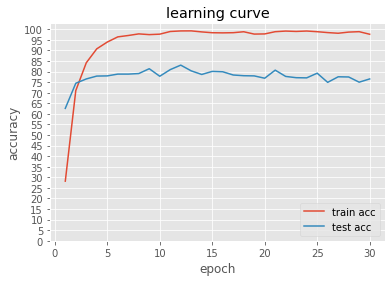

In [5]:
# 可视化训练过程
train_acc_result = []
for record in record_train:
    train_acc_result.append(record.cuda().data.cpu().numpy())

plt.style.use("ggplot")
plt.plot(range(1, len(train_acc_result) + 1), train_acc_result, label="train acc")
if record_test is not None:
    plt.plot(range(1, len(record_test) + 1), record_test, label="test acc")

plt.legend(loc=4)
plt.title("learning curve")
plt.xticks(range(0, len(train_acc_result) + 1, 5))
plt.yticks(range(0, 101, 5))
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()